In [49]:
# from google.colab import drive
# drive.mount('/content/drive')

In [50]:
import torch as torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from torch.optim import AdamW, LBFGS
from torch import GradScaler
from scipy.linalg import expm
from scipy.optimize import minimize

In [51]:
# One-qubit operators
sigma_x = torch.tensor([[0., 1.], [1., 0.]], dtype=torch.complex64)
sigma_y = torch.tensor([[0., -1j], [1j, 0.]], dtype=torch.complex64)
sigma_z = torch.tensor([[1., 0.], [0., -1.]], dtype=torch.complex64)
identity = torch.eye(2, dtype=torch.complex64)
# Two-qubit operators
# Qubit 1 controls
sx1 = torch.kron(sigma_x, identity)  # σₓ ⊗ I
sz1 = torch.kron(sigma_z, identity)  # σ_z ⊗ I
# Qubit 2 controls
sx2 = torch.kron(identity, sigma_x)  # I ⊗ σₓ
sz2 = torch.kron(identity, sigma_z)  # I ⊗ σ_z
# Coupling
szx = torch.kron(sigma_z, sigma_x)  # σ_z ⊗ σ_x

In [52]:
H_target = (1/np.sqrt(2)) * torch.tensor([[1., 1.], [1., -1.]], dtype=torch.complex64)
T_target = torch.tensor([[1., 0.], [0., np.exp(1j * np.pi / 4)]], dtype=torch.complex64)
CNOT_target = torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
], dtype=torch.complex64)

In [53]:
# System parameters
T_total = 1.0    # total time
N = 10          # number of time steps
dt = 1 / 9 # delta time
time_grid = torch.linspace(0, T_total, N)
K = 5
freqs = torch.linspace(1.0, 5.0, K)
omega0 = 2 * np.pi / T_total

In [54]:
# GRAPE
def propagate_grape(params, target):
  if target.shape[0] == 2:
    u_x = params['ux']
    u_z = params['uz']
    U = torch.eye(2, dtype=torch.complex64)
    for n in range(N):
      H = u_x[n] * sigma_x + u_z[n] * sigma_z
      U_step = torch.matrix_exp(-1j * H * dt)
      U = U_step @ U
  else:
    u1x = params['u1x']
    u1z = params['u1z']
    u2x = params['u2x']
    u2z = params['u2z']
    jzx = params['jzx']
    U = torch.eye(4, dtype=torch.complex64)
    for n in range(N):
      H = jzx[n] * szx + u1x[n] * sx1 + u1z[n] * sz1 + u2x[n] * sx2 + u2z[n] * sz2
      U_step = torch.matrix_exp(-1j * H * dt)
      U = U_step @ U
  return U

def process_fidelity_grape(U, U_target):
    dim = U_target.shape[0]
    fidelity = torch.clamp((torch.abs(torch.trace(U_target.conj().T @ U) / dim))**2, 0, 1)
    infidelity = torch.log10(1 - fidelity)
    return fidelity.item(), infidelity.item()

def loss_fn_grape(U, U_target):
    # Compute the global phase factor from the trace overlap
    trace_val = torch.trace(U_target.conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = torch.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = torch.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = U_target - U_aligned
    loss = torch.norm(diff, p='fro')**2
    return loss

def train_grape(iters, optimizer, params, target):
  scaler = GradScaler('cpu')
  loss_list, fid_list, inf_list = [], [], []
  for it in range(iters):
    optimizer.zero_grad(set_to_none=True)
    U = propagate_grape(params, target)
    loss = loss_fn_grape(U, target)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    fid, inf = process_fidelity_grape(U, target)
    loss_list.append(loss.item())
    fid_list.append(fid)
    inf_list.append(inf)
    if it % 100 == 0 or it == num_iters-1:
        print(f"Iteration {it}: Loss = {loss.item()}")
        print(f"Fidelity = {fid}, Infidelity = {inf}")
  return loss_list, fid_list, inf_list

In [55]:
# CRAB
def process_fidelity_crab(U, U_target):
    dim = U_target.shape[0]
    fidelity = np.clip((np.abs(np.trace(U_target.conj().T @ U) / dim))**2, 0, 1)
    infidelity = np.log10(1 - fidelity)
    return fidelity.item(), infidelity.item()

def drive_control(t, x):
    # x[0:K]: alpha coefficients, x[K:2K]: beta coefficients.
    alphas = x[:K]
    betas = x[K:2*K]
    pulse = 0.0
    for k in range(1, K+1):
        pulse += alphas[k-1] * np.cos(k * omega0 * t) + betas[k-1] * np.sin(k * omega0 * t)
    return pulse

def detuning_control(t, x):
    # x[2K:3K]: gamma coefficients, x[3K:4K]: delta coefficients.
    gammas = x[2*K:3*K]
    deltas = x[3*K:4*K]
    pulse = 0.0
    for k in range(1, K+1):
        pulse += gammas[k-1] * np.cos(k * omega0 * t) + deltas[k-1] * np.sin(k * omega0 * t)
    return pulse

# Total control pulse applied in the Hamiltonian.
# H(t) = εₓ(t) σ_x + ε_z(t) σ_z.
def hamiltonian(t, x):
    eps_x = drive_control(t, x)
    eps_z = detuning_control(t, x)
    return eps_x * sigma_x + eps_z * sigma_z

def propagate_crab(x):
  U = np.eye(2).copy()
  for t in time_grid:
    H = hamiltonian(t, x)
    U_step = expm(-1j * H * dt)
    U = U_step @ U
  return U

In [56]:
ux_grape_h_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_h_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_h_adam, 'uz': uz_grape_h_adam}
optimizer = AdamW([ux_grape_h_adam, uz_grape_h_adam], lr=0.001, weight_decay=0.001)

In [57]:
num_iters = 3000
loss_list_grape_h_adam, fid_list_grape_h_adam, inf_list_grape_h_adam = train_grape(num_iters, optimizer, params, H_target)

Iteration 0: Loss = 2.4357845783233643
Fidelity = 0.1529228389263153, Infidelity = -0.07207704335451126
Iteration 100: Loss = 1.8986268043518066
Fidelity = 0.27598509192466736, Infidelity = -0.1402525156736374
Iteration 200: Loss = 1.4335771799087524
Fidelity = 0.411657452583313, Infidelity = -0.23036974668502808
Iteration 300: Loss = 1.0488249063491821
Fidelity = 0.5443388223648071, Infidelity = -0.3413579761981964
Iteration 400: Loss = 0.7441351413726807
Fidelity = 0.6625397205352783, Infidelity = -0.4717773497104645
Iteration 500: Loss = 0.5129150152206421
Fidelity = 0.7599837779998779, Infidelity = -0.6197593808174133
Iteration 600: Loss = 0.34444013237953186
Fidelity = 0.8351932764053345, Infidelity = -0.7830250859260559
Iteration 700: Loss = 0.2262069582939148
Fidelity = 0.890092670917511, Infidelity = -0.9589733481407166
Iteration 800: Loss = 0.14592650532722473
Fidelity = 0.9283657073974609, Infidelity = -1.1448789834976196
Iteration 900: Loss = 0.09286687523126602
Fidelity = 0

In [58]:
ux_grape_h_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_h_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_h_lbfgs, 'uz': uz_grape_h_lbfgs}

loss_list_grape_h_lbfgs, fid_list_grape_h_lbfgs, inf_list_grape_h_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, H_target)
  loss = loss_fn_grape(U, H_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, H_target)
  loss_list_grape_h_lbfgs.append(loss.item())
  fid_list_grape_h_lbfgs.append(fid)
  inf_list_grape_h_lbfgs.append(inf)
  return loss

optimizer = LBFGS([ux_grape_h_lbfgs , uz_grape_h_lbfgs], lr=0.001, max_iter=10)

num_iterations = 300
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_grape_h_lbfgs[-1]}, Infidelity: {inf_list_grape_h_lbfgs[-1]}")

Iteration 0, Loss: 3.0909786224365234
Fidelity: 0.131736621260643, Infidelity: -0.06134852394461632
Iteration 10, Loss: 1.2248246669769287
Fidelity: 0.506237804889679, Infidelity: -0.3064821660518646
Iteration 20, Loss: 0.43606311082839966
Fidelity: 0.8065512180328369, Infidelity: -0.7134339809417725
Iteration 30, Loss: 0.1908709704875946
Fidelity: 0.9138104915618896, Infidelity: -1.0645456314086914
Iteration 40, Loss: 0.09318965673446655
Fidelity: 0.957168459892273, Infidelity: -1.3682363033294678
Iteration 50, Loss: 0.042809754610061646
Fidelity: 0.9798259735107422, Infidelity: -1.6952073574066162
Iteration 60, Loss: 0.01964600197970867
Fidelity: 0.9908513426780701, Infidelity: -2.038642644882202
Iteration 70, Loss: 0.010002980940043926
Fidelity: 0.995369553565979, Infidelity: -2.3343770503997803
Iteration 80, Loss: 0.004775312263518572
Fidelity: 0.9977251291275024, Infidelity: -2.643043279647827
Iteration 90, Loss: 0.0023284724447876215
Fidelity: 0.9988822340965271, Infidelity: -2.9

In [59]:
loss_list_crab_h, fid_list_crab_h, inf_list_crab_h = [], [], []

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(H_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = H_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_h.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, H_target.numpy())
    fid_list_crab_h.append(fid)
    inf_list_crab_h.append(inf)
    return loss

In [60]:
x0 = np.random.randn(4 * K)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_2837475/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 679
         Function evaluations: 997


In [61]:
# h_adam = pd.read_csv("/home/pdconte/Desktop/DUTh_Thesis/Analysis/grape_h_adam.csv")
# h_lbfgs = pd.read_csv("/home/pdconte/Desktop/DUTh_Thesis/Analysis/grape_h_lbfgs.csv")
# h_crab = pd.read_csv("/home/pdconte/Desktop/DUTh_Thesis/Analysis/crab_h.csv")

# fid_list_grape_h_adam = h_adam["fid_grape_h_adam"].tolist()
# fid_list_grape_h_lbfgs = h_lbfgs["fid_grape_h_lbfgs"].tolist()
# fid_list_crab_h = h_crab["fid_crab_h"].tolist()
# inf_list_grape_h_adam = h_adam["inf_grape_h_adam"].tolist()
# inf_list_grape_h_lbfgs = h_lbfgs["inf_grape_h_lbfgs"].tolist()
# inf_list_crab_h = h_crab["inf_crab_h"].tolist()
# loss_list_grape_h_adam = h_adam["loss_grape_h_adam"].tolist()
# loss_list_grape_h_lbfgs = h_lbfgs["loss_grape_h_lbfgs"].tolist()
# loss_list_crab_h = h_crab["loss_crab_h"].tolist()

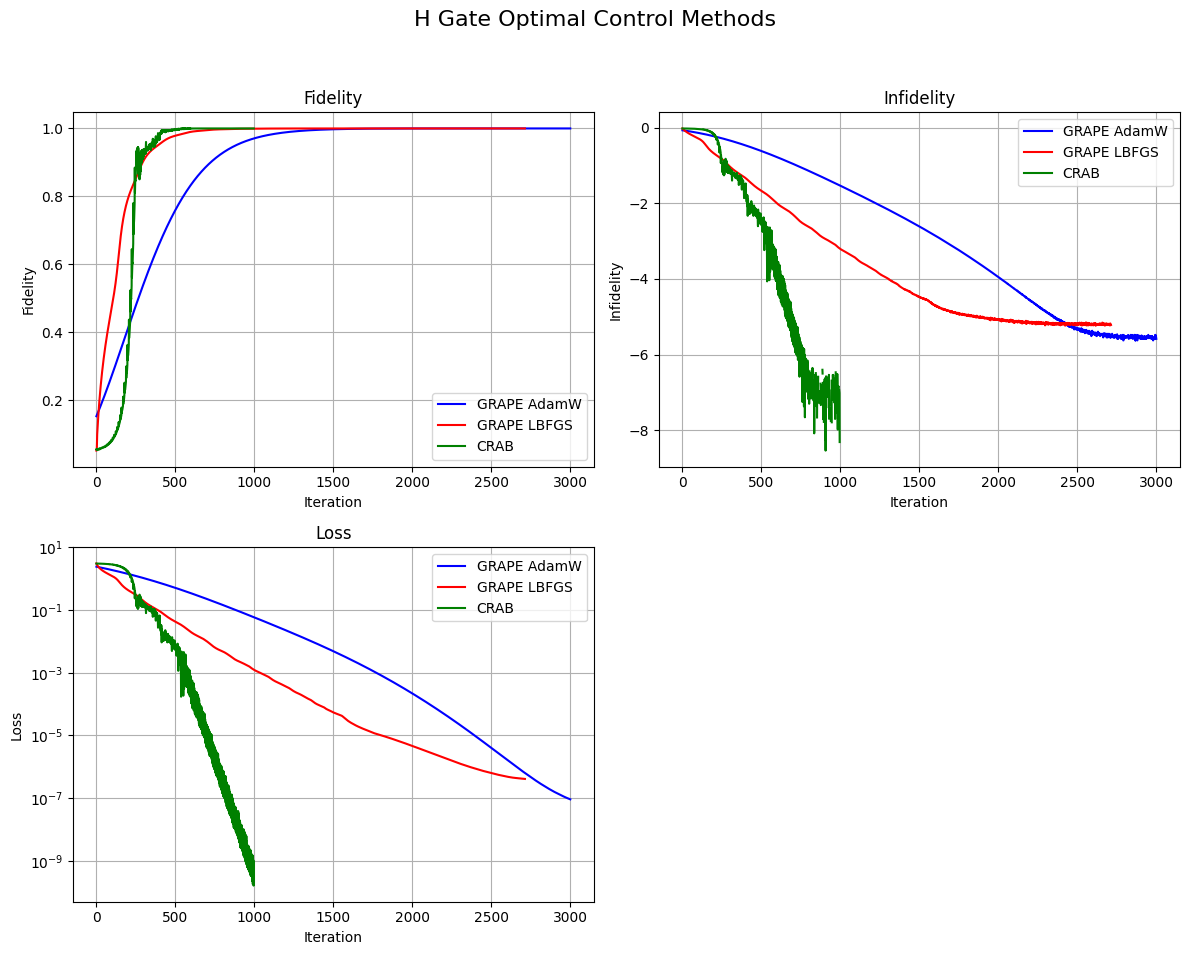

In [62]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("H Gate Optimal Control Methods", fontsize=16)

# First row, first column: Fidelity plot
axs[0, 0].plot(fid_list_grape_h_adam, label="GRAPE AdamW", color="blue")
axs[0, 0].plot(fid_list_grape_h_lbfgs, label="GRAPE LBFGS", color="red")
axs[0, 0].plot(fid_list_crab_h, label="CRAB", color="green")
axs[0, 0].set_title("Fidelity")
axs[0, 0].set_xlabel("Iteration")
axs[0, 0].set_ylabel("Fidelity")
axs[0, 0].legend()
axs[0, 0].grid()

# First row, second column: Infidelity plot
axs[0, 1].plot(inf_list_grape_h_adam, label="GRAPE AdamW", color="blue")
axs[0, 1].plot(inf_list_grape_h_lbfgs, label="GRAPE LBFGS", color="red")
axs[0, 1].plot(inf_list_crab_h, label="CRAB", color="green")
axs[0, 1].set_title("Infidelity")
axs[0, 1].set_xlabel("Iteration")
axs[0, 1].set_ylabel("Infidelity")
axs[0, 1].legend()
axs[0, 1].grid()

# Second row, first column: Loss plot
axs[1, 0].plot(loss_list_grape_h_adam, label="GRAPE AdamW", color="blue")
axs[1, 0].plot(loss_list_grape_h_lbfgs, label="GRAPE LBFGS", color="red")
axs[1, 0].plot(loss_list_crab_h, label="CRAB", color="green")
axs[1, 0].set_title("Loss")
axs[1, 0].set_xlabel("Iteration")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_yscale("log")
axs[1, 0].legend()
axs[1, 0].grid()

# Second row, second column: Turn off the unused subplot
axs[1, 1].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/H_Gate_Optimal_Control_Methods.png"
)
plt.show()

In [63]:
pd.DataFrame({'loss_grape_h_adam': loss_list_grape_h_adam, 'fid_grape_h_adam': fid_list_grape_h_adam, 'inf_grape_h_adam': inf_list_grape_h_adam}).to_csv('grape_h_adam.csv')
pd.DataFrame({'loss_grape_h_lbfgs': loss_list_grape_h_lbfgs, 'fid_grape_h_lbfgs': fid_list_grape_h_lbfgs, 'inf_grape_h_lbfgs': inf_list_grape_h_lbfgs}).to_csv('grape_h_lbfgs.csv')
pd.DataFrame({'loss_crab_h': loss_list_crab_h, 'fid_crab_h': fid_list_crab_h, 'inf_crab_h': inf_list_crab_h}).to_csv('crab_h.csv')

In [64]:
# Plot the optimized control pulses
time_edges = np.linspace(0, T_total, N+1)
ux_grape_h_adam = ux_grape_h_adam.detach().cpu().numpy()
uz_grape_h_adam = uz_grape_h_adam.detach().cpu().numpy()
ux_grape_h_lbfgs = ux_grape_h_lbfgs.detach().cpu().numpy()
uz_grape_h_lbfgs = uz_grape_h_lbfgs.detach().cpu().numpy()

x_opt = res.x
ux_grape_h_crab = [drive_control(t, x_opt) for t in time_grid]
uz_grape_h_crab = [detuning_control(t, x_opt) for t in time_grid]

In [65]:
# Normalize the data arrays
ux_grape_h_adam_norm = normalize(ux_grape_h_adam)
uz_grape_h_adam_norm = normalize(uz_grape_h_adam)
ux_grape_h_lbfgs_norm = normalize(ux_grape_h_lbfgs)
uz_grape_h_lbfgs_norm = normalize(uz_grape_h_lbfgs)
ux_grape_h_crab_norm = normalize(ux_grape_h_crab)
uz_grape_h_crab_norm = normalize(uz_grape_h_crab)

# Normalize the time axis as t/Tmax, where Tmax is the final time value
Tmax_h = time_edges[-1]
t_normalized_h = time_edges / Tmax_h

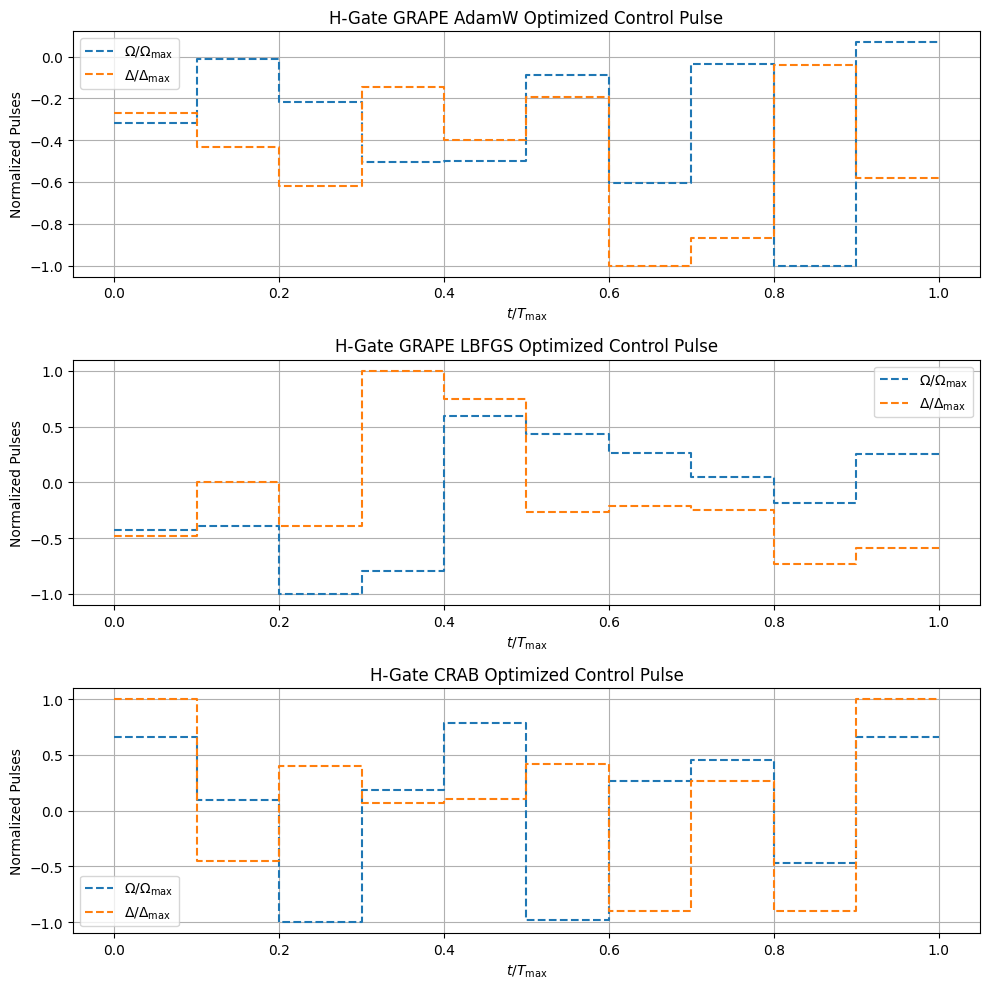

In [66]:
# Define a normalization function
def normalize(arr):
    return arr / np.max(np.abs(arr))

plt.figure(figsize=(10, 10))

# GRAPE AdamW Plot
plt.subplot(3, 1, 1)
plt.step(
    t_normalized_h,
    np.append(ux_grape_h_adam_norm, ux_grape_h_adam_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized_h,
    np.append(uz_grape_h_adam_norm, uz_grape_h_adam_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.title("H-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)

# GRAPE LBFGS Plot
plt.subplot(3, 1, 2)
plt.step(
    t_normalized_h,
    np.append(ux_grape_h_lbfgs_norm, ux_grape_h_lbfgs_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized_h,
    np.append(uz_grape_h_lbfgs_norm, uz_grape_h_lbfgs_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.title("H-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)

# CRAB Plot
plt.subplot(3, 1, 3)
plt.step(
    t_normalized_h,
    np.append(ux_grape_h_crab_norm, ux_grape_h_crab_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized_h,
    np.append(uz_grape_h_crab_norm, uz_grape_h_crab_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.title("H-Gate CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/H_Gate_Optimal_Control_Pulses_Normalized.png"
)
plt.show()

In [67]:
# T-Gate
dt = 1/10
ux_grape_t_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_t_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_t_adam, 'uz': uz_grape_t_adam}
optimizer = AdamW([ux_grape_t_adam, uz_grape_t_adam], lr=0.001, weight_decay=0.001)

In [68]:
num_iters = 1200
loss_list_grape_t_adam, fid_list_grape_t_adam, inf_list_grape_t_adam = train_grape(num_iters, optimizer, params, T_target)

Iteration 0: Loss = 0.39694544672966003
Fidelity = 0.8113750219345093, Infidelity = -0.7244008183479309
Iteration 100: Loss = 0.20142705738544464
Fidelity = 0.9018222093582153, Infidelity = -1.0079867839813232
Iteration 200: Loss = 0.09020046144723892
Fidelity = 0.9554083943367004, Infidelity = -1.3507468700408936
Iteration 300: Loss = 0.036032550036907196
Fidelity = 0.9820646643638611, Infidelity = -1.7462904453277588
Iteration 400: Loss = 0.013634933158755302
Fidelity = 0.9931939244270325, Infidelity = -2.1671032905578613
Iteration 500: Loss = 0.005772776901721954
Fidelity = 0.9971155524253845, Infidelity = -2.5399372577667236
Iteration 600: Loss = 0.003365766955539584
Fidelity = 0.9983178377151489, Infidelity = -2.774132013320923
Iteration 700: Loss = 0.0026494942139834166
Fidelity = 0.9986752867698669, Infidelity = -2.877878189086914
Iteration 800: Loss = 0.0023690913803875446
Fidelity = 0.9988157749176025, Infidelity = -2.926565647125244
Iteration 900: Loss = 0.0021824627183377743

In [69]:
ux_grape_t_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_t_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_t_lbfgs, 'uz': uz_grape_t_lbfgs}

loss_list_grape_t_lbfgs, fid_list_grape_t_lbfgs, inf_list_grape_t_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, T_target)
  loss = loss_fn_grape(U, T_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, T_target)
  loss_list_grape_t_lbfgs.append(loss.item())
  fid_list_grape_t_lbfgs.append(fid)
  inf_list_grape_t_lbfgs.append(inf)
  return loss

optimizer = LBFGS([ux_grape_t_lbfgs , uz_grape_t_lbfgs], lr=0.001, max_iter=10)

num_iterations = 120
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_grape_t_lbfgs[-1]}, Infidelity: {inf_list_grape_t_lbfgs[-1]}")

Iteration 0, Loss: 0.009956108406186104
Fidelity: 0.9950860738754272, Infidelity: -2.3085713386535645
Iteration 10, Loss: 0.006164797116070986
Fidelity: 0.9971027970314026, Infidelity: -2.5380210876464844
Iteration 20, Loss: 0.003368494100868702
Fidelity: 0.9984163641929626, Infidelity: -2.800344705581665
Iteration 30, Loss: 0.0018355519277974963
Fidelity: 0.999125063419342, Infidelity: -3.058023452758789
Iteration 40, Loss: 0.0010512490989640355
Fidelity: 0.9994980692863464, Infidelity: -3.29935622215271
Iteration 50, Loss: 0.0006364590954035521
Fidelity: 0.9996943473815918, Infidelity: -3.5147719383239746
Iteration 60, Loss: 0.00040483931661583483
Fidelity: 0.9998034238815308, Infidelity: -3.7064692974090576
Iteration 70, Loss: 0.00028021560865454376
Fidelity: 0.9998624324798584, Infidelity: -3.8614840507507324
Iteration 80, Loss: 0.00021464434394147247
Fidelity: 0.9998928308486938, Infidelity: -3.9699301719665527
Iteration 90, Loss: 0.00017177303379867226
Fidelity: 0.999913454055786

In [70]:
loss_list_crab_t, fid_list_crab_t, inf_list_crab_t = [], [], []

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(T_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = T_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_t.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, T_target.numpy())
    fid_list_crab_t.append(fid)
    inf_list_crab_t.append(inf)
    return loss

x0 = np.random.randn(4 * K)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_2837475/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 806
         Function evaluations: 1172


In [71]:
# t_adam = pd.read_csv("/home/pdconte/Desktop/DUTh_Thesis/Analysis/grape_t_adam.csv")
# t_lbfgs = pd.read_csv("/home/pdconte/Desktop/DUTh_Thesis/Analysis/grape_t_lbfgs.csv")
# t_crab = pd.read_csv("/home/pdconte/Desktop/DUTh_Thesis/Analysis/crab_t.csv")

# fid_list_grape_t_adam = t_adam["fid_grape_t_adam"].tolist()
# fid_list_grape_t_lbfgs = t_lbfgs["fid_grape_t_lbfgs"].tolist()
# fid_list_crab_t = t_crab["fid_crab_t"].tolist()
# inf_list_grape_t_adam = t_adam["inf_grape_t_adam"].tolist()
# inf_list_grape_t_lbfgs = t_lbfgs["inf_grape_t_lbfgs"].tolist()
# inf_list_crab_t = t_crab["inf_crab_t"].tolist()
# loss_list_grape_t_adam = t_adam["loss_grape_t_adam"].tolist()
# loss_list_grape_t_lbfgs = t_lbfgs["loss_grape_t_lbfgs"].tolist()
# loss_list_crab_t = t_crab["loss_crab_t"].tolist()

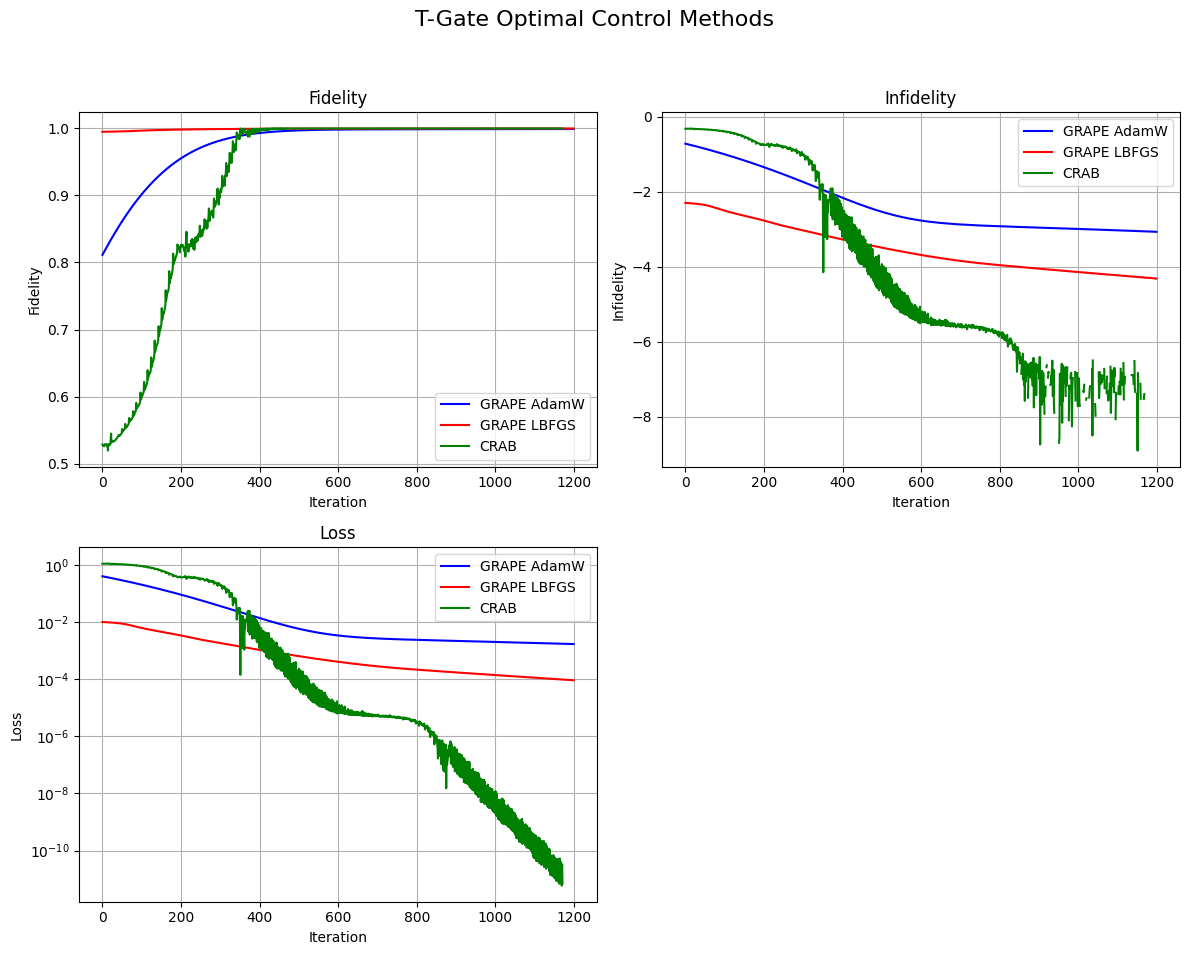

In [72]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("T-Gate Optimal Control Methods", fontsize=16)

# First row, first column: Fidelity plot
axs[0, 0].plot(fid_list_grape_t_adam, label="GRAPE AdamW", color="blue")
axs[0, 0].plot(fid_list_grape_t_lbfgs, label="GRAPE LBFGS", color="red")
axs[0, 0].plot(fid_list_crab_t, label="CRAB", color="green")
axs[0, 0].set_title("Fidelity")
axs[0, 0].set_xlabel("Iteration")
axs[0, 0].set_ylabel("Fidelity")
axs[0, 0].legend()
axs[0, 0].grid()

# First row, second column: Infidelity plot
axs[0, 1].plot(inf_list_grape_t_adam, label="GRAPE AdamW", color="blue")
axs[0, 1].plot(inf_list_grape_t_lbfgs, label="GRAPE LBFGS", color="red")
axs[0, 1].plot(inf_list_crab_t, label="CRAB", color="green")
axs[0, 1].set_title("Infidelity")
axs[0, 1].set_xlabel("Iteration")
axs[0, 1].set_ylabel("Infidelity")
axs[0, 1].legend()
axs[0, 1].grid()

# Second row, first column: Loss plot
axs[1, 0].plot(loss_list_grape_t_adam, label="GRAPE AdamW", color="blue")
axs[1, 0].plot(loss_list_grape_t_lbfgs, label="GRAPE LBFGS", color="red")
axs[1, 0].plot(loss_list_crab_t, label="CRAB", color="green")
axs[1, 0].set_title("Loss")
axs[1, 0].set_xlabel("Iteration")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_yscale("log")
axs[1, 0].legend()
axs[1, 0].grid()

# Second row, second column: Turn off the unused subplot
axs[1, 1].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/T_Gate_Optimal_Control_Methods.png"
)
plt.show()

In [73]:
pd.DataFrame({'loss_grape_t_adam': loss_list_grape_t_adam, 'fid_grape_t_adam': fid_list_grape_t_adam, 'inf_grape_t_adam': inf_list_grape_t_adam}).to_csv('grape_t_adam.csv')
pd.DataFrame({'loss_grape_t_lbfgs': loss_list_grape_t_lbfgs, 'fid_grape_t_lbfgs': fid_list_grape_t_lbfgs, 'inf_grape_t_lbfgs': inf_list_grape_t_lbfgs}).to_csv('grape_t_lbfgs.csv')
pd.DataFrame({'loss_crab_t': loss_list_crab_t, 'fid_crab_t': fid_list_crab_t, 'inf_crab_t': inf_list_crab_t}).to_csv('crab_t.csv')

In [74]:
# Plot the optimized control pulses
time_edges = np.linspace(0, T_total, N+1)
ux_grape_t_adam = ux_grape_t_adam.detach().cpu().numpy()
uz_grape_t_adam = uz_grape_t_adam.detach().cpu().numpy()
ux_grape_t_lbfgs = ux_grape_t_lbfgs.detach().cpu().numpy()
uz_grape_t_lbfgs = uz_grape_t_lbfgs.detach().cpu().numpy()
x_opt = res.x
ux_grape_t_crab = [drive_control(t, x_opt) for t in time_grid]
uz_grape_t_crab = [detuning_control(t, x_opt) for t in time_grid]

In [75]:
# Normalize the T-gate data arrays
ux_grape_t_adam_norm = normalize(ux_grape_t_adam)
uz_grape_t_adam_norm = normalize(uz_grape_t_adam)
ux_grape_t_lbfgs_norm = normalize(ux_grape_t_lbfgs)
uz_grape_t_lbfgs_norm = normalize(uz_grape_t_lbfgs)
ux_grape_t_crab_norm = normalize(ux_grape_t_crab)
uz_grape_t_crab_norm = normalize(uz_grape_t_crab)

# Normalize the time axis: t/Tmax (Tmax is the final time value)
Tmax_t = time_edges[-1]
t_normalized_t = time_edges / Tmax_t

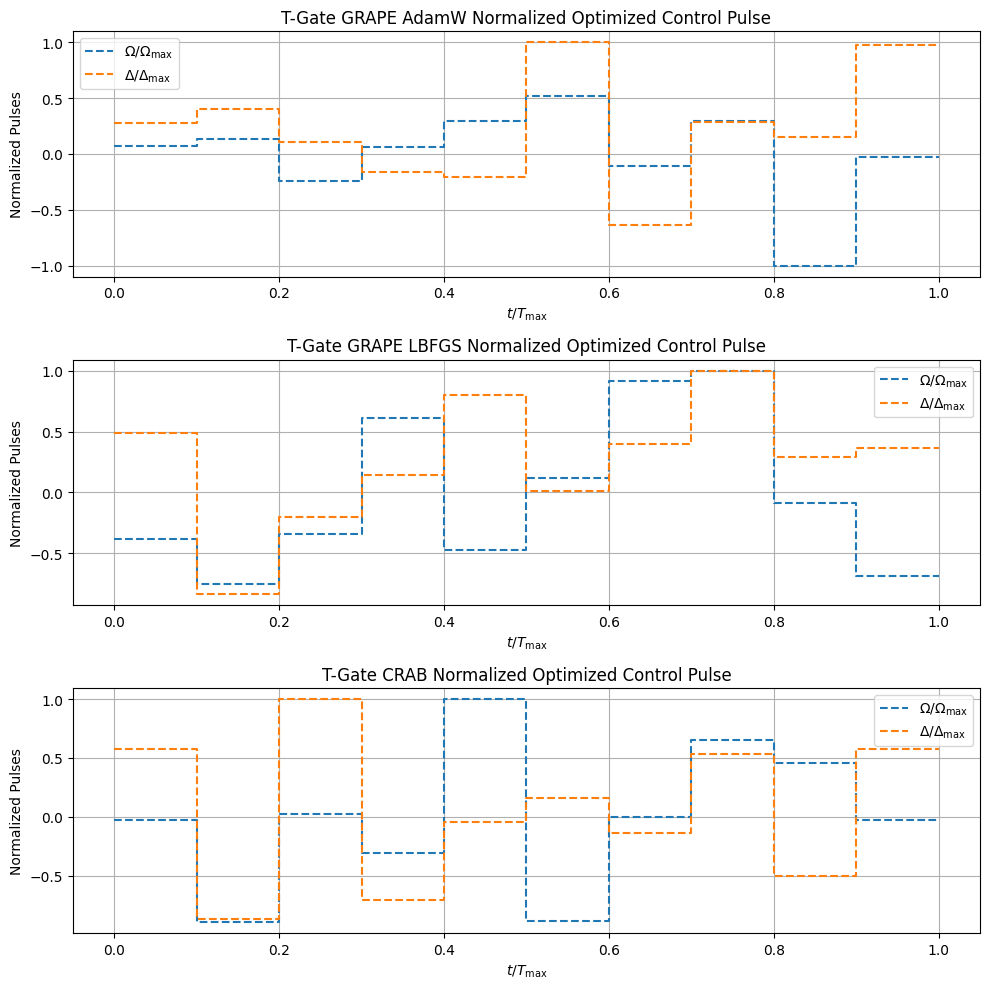

In [76]:
plt.figure(figsize=(10, 10))

# GRAPE AdamW Plot for T-Gate
plt.subplot(3, 1, 1)
plt.step(
    t_normalized_t,
    np.append(ux_grape_t_adam_norm, ux_grape_t_adam_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized_t,
    np.append(uz_grape_t_adam_norm, uz_grape_t_adam_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel("Normalized Pulses")
plt.title("T-Gate GRAPE AdamW Normalized Optimized Control Pulse")
plt.legend()
plt.grid(True)

# GRAPE LBFGS Plot for T-Gate
plt.subplot(3, 1, 2)
plt.step(
    t_normalized_t,
    np.append(ux_grape_t_lbfgs_norm, ux_grape_t_lbfgs_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized_t,
    np.append(uz_grape_t_lbfgs_norm, uz_grape_t_lbfgs_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel("Normalized Pulses")
plt.title("T-Gate GRAPE LBFGS Normalized Optimized Control Pulse")
plt.legend()
plt.grid(True)

# CRAB Plot for T-Gate
plt.subplot(3, 1, 3)
plt.step(
    t_normalized_t,
    np.append(ux_grape_t_crab_norm, ux_grape_t_crab_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
)
plt.step(
    t_normalized_t,
    np.append(uz_grape_t_crab_norm, uz_grape_t_crab_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel("Normalized Pulses")
plt.title("T-Gate CRAB Normalized Optimized Control Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/T_Gate_Optimal_Control_Pulses_Normalized.png"
)
plt.show()

In [77]:
N = 5  # number of time steps
dt = 1/5  # delta time
time_grid = torch.linspace(0, T_total, N)

In [78]:
u1x_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σₓ control
u1z_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σ_z control
u2x_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σₓ control
u2z_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σ_z control
jzx_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Coupling Strength
params = {'u1x': u1x_grape_cnot_adam, 'u1z': u1z_grape_cnot_adam, 'u2x': u2x_grape_cnot_adam, 'u2z': u2z_grape_cnot_adam, 'jzx': jzx_grape_cnot_adam}
optimizer = AdamW([u1x_grape_cnot_adam, u1z_grape_cnot_adam, u2x_grape_cnot_adam, u2z_grape_cnot_adam, jzx_grape_cnot_adam], lr=0.001, weight_decay=0.001)

In [79]:
num_iters = 3000
loss_list_cnot_grape_adam, fid_list_cnot_grape_adam, inf_list_cnot_grape_adam = train_grape(num_iters, optimizer, params, CNOT_target)

Iteration 0: Loss = 1.3352850675582886
Fidelity = 0.6940351724624634, Infidelity = -0.5143284797668457
Iteration 100: Loss = 0.7222757935523987
Fidelity = 0.8275801539421082, Infidelity = -0.7634127736091614
Iteration 200: Loss = 0.3616161644458771
Fidelity = 0.9116367697715759, Infidelity = -1.053728461265564
Iteration 300: Loss = 0.17690499126911163
Fidelity = 0.9562605023384094, Infidelity = -1.3591262102127075
Iteration 400: Loss = 0.08773326128721237
Fidelity = 0.9781841039657593, Infidelity = -1.6612269878387451
Iteration 500: Loss = 0.04551387205719948
Fidelity = 0.9886508584022522, Infidelity = -1.9450370073318481
Iteration 600: Loss = 0.02537825144827366
Fidelity = 0.9936627745628357, Infidelity = -2.1981008052825928
Iteration 700: Loss = 0.015351212583482265
Fidelity = 0.9961626529693604, Infidelity = -2.415968894958496
Iteration 800: Loss = 0.009926746599376202
Fidelity = 0.9975138902664185, Infidelity = -2.6044797897338867
Iteration 900: Loss = 0.006682176608592272
Fidelity

In [80]:
u1x_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σₓ control
u1z_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σ_z control
u2x_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σₓ control
u2z_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σ_z control
jzx_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Coupling Strength
params = {'u1x': u1x_grape_cnot_lbfgs, 'u1z': u1z_grape_cnot_lbfgs, 'u2x': u2x_grape_cnot_lbfgs, 'u2z': u2z_grape_cnot_lbfgs, 'jzx': jzx_grape_cnot_lbfgs}

loss_list_cnot_grape_lbfgs, fid_list_cnot_grape_lbfgs, inf_list_cnot_grape_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, CNOT_target)
  loss = loss_fn_grape(U, CNOT_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, CNOT_target)
  loss_list_cnot_grape_lbfgs.append(loss.item())
  fid_list_cnot_grape_lbfgs.append(fid)
  inf_list_cnot_grape_lbfgs.append(inf)
  return loss

optimizer = LBFGS([u1x_grape_cnot_lbfgs, u1z_grape_cnot_lbfgs, u2x_grape_cnot_lbfgs, u2z_grape_cnot_lbfgs, jzx_grape_cnot_lbfgs], lr=0.001, max_iter=10)

num_iterations = 300
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_cnot_grape_lbfgs[-1]}, Infidelity: {inf_list_cnot_grape_lbfgs[-1]}")

Iteration 0, Loss: 4.465120315551758
Fidelity: 0.1979602873325348, Infidelity: -0.0958041101694107
Iteration 10, Loss: 4.1563215255737305
Fidelity: 0.23434485495090485, Infidelity: -0.1159667894244194
Iteration 20, Loss: 3.825460195541382
Fidelity: 0.27628934383392334, Infidelity: -0.14043503999710083
Iteration 30, Loss: 3.482353925704956
Fidelity: 0.3233034610748291, Infidelity: -0.1696060448884964
Iteration 40, Loss: 0.7346054315567017
Fidelity: 0.8332035541534424, Infidelity: -0.777813196182251
Iteration 50, Loss: 0.4180244505405426
Fidelity: 0.9037578105926514, Infidelity: -1.016634464263916
Iteration 60, Loss: 0.24491189420223236
Fidelity: 0.9422667622566223, Infidelity: -1.2385740280151367
Iteration 70, Loss: 0.1525728553533554
Fidelity: 0.9636308550834656, Infidelity: -1.4392669200897217
Iteration 80, Loss: 0.10573072731494904
Fidelity: 0.9745110273361206, Infidelity: -1.5936477184295654
Iteration 90, Loss: 0.07784145325422287
Fidelity: 0.9810918569564819, Infidelity: -1.7233511

In [81]:
num_channels = 5   # drive, detuning, coupling.
N_params = num_channels * (2 * K)

loss_list_crab_cnot, fid_list_crab_cnot, inf_list_crab_cnot = [], [], []

# Function to construct a control pulse at time t given Fourier coefficients.
def control_pulse(t, coeffs):
    # coeffs is a vector of length 2*K.
    val = 0.0
    for k in range(1, K+1):
        alpha = coeffs[k-1]
        beta  = coeffs[K + k - 1]
        val += alpha * np.cos(k * omega0 * t) + beta * np.sin(k * omega0 * t)
    return val

# Full Hamiltonian at time t, given control parameters x.
def H_total(t, x):
    # Channel 1: drive1 (first 2*K coefficients)
    # Channel 2: detuning1 (next 2*K)
    # Channel 3: drive2 (next 2*K)
    # Channel 4: detuning2 (next 2*K)
    # Channel 5: coupling (last 2*K)
    coeff_drive1    = x[0:2*K]
    coeff_detuning1 = x[2*K:4*K]
    coeff_drive2    = x[4*K:6*K]
    coeff_detuning2 = x[6*K:8*K]
    coeff_coupling  = x[8*K:10*K]

    eps_drive1    = control_pulse(t, coeff_drive1)
    eps_detuning1 = control_pulse(t, coeff_detuning1)
    eps_drive2    = control_pulse(t, coeff_drive2)
    eps_detuning2 = control_pulse(t, coeff_detuning2)
    eps_coupling  = control_pulse(t, coeff_coupling)

    H = (eps_drive1 * sx1 +
         eps_detuning1 * sz1 +
         eps_drive2 * sx2+
         eps_detuning2 * sz2 +
         eps_coupling * szx)
    return H

def propagate_crab(x):
    U = np.eye(4, dtype=complex)
    for t in time_grid:
        H = H_total(t, x)
        U_step = expm(-1j * H * dt)
        U = U_step @ U
    return U

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(CNOT_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = CNOT_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_cnot.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, CNOT_target.numpy())
    fid_list_crab_cnot.append(fid)
    inf_list_crab_cnot.append(inf)
    return loss

x0 = np.random.randn(N_params)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 10000, 'disp': True})# Optimize using Nelder-Mead.

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 5735
         Function evaluations: 7098


In [82]:
# cnot_adam = pd.read_csv("/home/pdconte/Desktop/DUTh_Thesis/Analysis/grape_cnot_adam.csv")
# cnot_lbfgs = pd.read_csv("/home/pdconte/Desktop/DUTh_Thesis/Analysis/grape_cnot_lbfgs.csv")
# cnot_crab = pd.read_csv("/home/pdconte/Desktop/DUTh_Thesis/Analysis/crab_cnot.csv")
# fid_list_grape_cnot_adam = cnot_adam["fid_grape_cnot_adam"].tolist()
# fid_list_grape_cnot_lbfgs = cnot_lbfgs["fid_grape_cnot_lbfgs"].tolist()
# fid_list_crab_cnot = cnot_crab["fid_crab_cnot"].tolist()
# inf_list_grape_cnot_adam = cnot_adam["inf_grape_cnot_adam"].tolist()
# inf_list_grape_cnot_lbfgs = cnot_lbfgs["inf_grape_cnot_lbfgs"].tolist()
# inf_list_crab_cnot = cnot_crab["inf_crab_cnot"].tolist()
# loss_list_grape_cnot_adam = cnot_adam["loss_grape_cnot_adam"].tolist()
# loss_list_grape_cnot_lbfgs = cnot_lbfgs["loss_grape_cnot_lbfgs"].tolist()
# loss_list_crab_cnot = cnot_crab["loss_crab_cnot"].tolist()

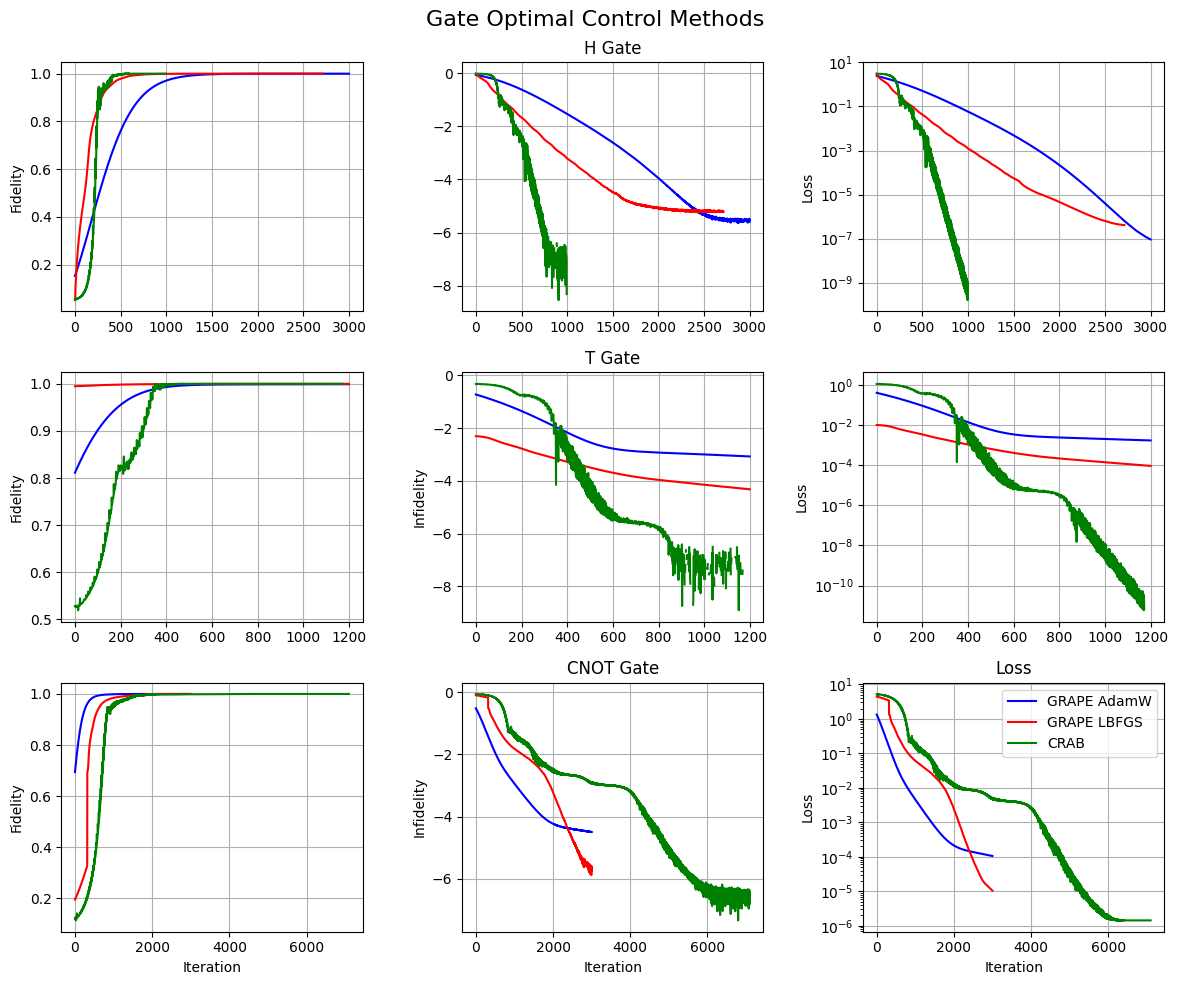

In [83]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
fig.suptitle("Gate Optimal Control Methods", fontsize=16)

# First row, first column: Fidelity plot
axs[0, 0].plot(fid_list_grape_h_adam, label="GRAPE AdamW", color="blue")
axs[0, 0].plot(fid_list_grape_h_lbfgs, label="GRAPE LBFGS", color="red")
axs[0, 0].plot(fid_list_crab_h, label="CRAB", color="green")
axs[0, 0].set_ylabel("Fidelity")
axs[0, 0].grid()

# First row, second column: Infidelity plot
axs[0, 1].plot(inf_list_grape_h_adam, label="GRAPE AdamW", color="blue")
axs[0, 1].plot(inf_list_grape_h_lbfgs, label="GRAPE LBFGS", color="red")
axs[0, 1].plot(inf_list_crab_h, label="CRAB", color="green")
axs[0, 1].grid()
axs[0, 1].set_title("H Gate")

# Second row, first column: Loss plot
axs[0, 2].plot(loss_list_grape_h_adam, label="GRAPE AdamW", color="blue")
axs[0, 2].plot(loss_list_grape_h_lbfgs, label="GRAPE LBFGS", color="red")
axs[0, 2].plot(loss_list_crab_h, label="CRAB", color="green")
axs[0, 2].set_ylabel("Loss")
axs[0, 2].set_yscale("log")
axs[0, 2].grid()

# First row, first column: Fidelity plot
axs[1, 0].plot(fid_list_grape_t_adam, label="GRAPE AdamW", color="blue")
axs[1, 0].plot(fid_list_grape_t_lbfgs, label="GRAPE LBFGS", color="red")
axs[1, 0].plot(fid_list_crab_t, label="CRAB", color="green")
axs[1, 0].set_ylabel("Fidelity")
axs[1, 0].grid()


# First row, second column: Infidelity plot
axs[1, 1].plot(inf_list_grape_t_adam, label="GRAPE AdamW", color="blue")
axs[1, 1].plot(inf_list_grape_t_lbfgs, label="GRAPE LBFGS", color="red")
axs[1, 1].plot(inf_list_crab_t, label="CRAB", color="green")
axs[1, 1].set_ylabel("Infidelity")
axs[1, 1].grid()
axs[1, 1].set_title("T Gate")

# Second row, first column: Loss plot
axs[1, 2].plot(loss_list_grape_t_adam, label="GRAPE AdamW", color="blue")
axs[1, 2].plot(loss_list_grape_t_lbfgs, label="GRAPE LBFGS", color="red")
axs[1, 2].plot(loss_list_crab_t, label="CRAB", color="green")
axs[1, 2].set_ylabel("Loss")
axs[1, 2].set_yscale("log")
axs[1, 2].grid()

# First row, first column: Fidelity plot
axs[2, 0].plot(fid_list_cnot_grape_adam, label="GRAPE AdamW", color="blue")
axs[2, 0].plot(fid_list_cnot_grape_lbfgs, label="GRAPE LBFGS", color="red")
axs[2, 0].plot(fid_list_crab_cnot, label="CRAB", color="green")
axs[2, 0].set_xlabel("Iteration")
axs[2, 0].set_ylabel("Fidelity")
axs[2, 0].grid()


# First row, second column: Infidelity plot
axs[2, 1].plot(inf_list_cnot_grape_adam, label="GRAPE AdamW", color="blue")
axs[2, 1].plot(inf_list_cnot_grape_lbfgs, label="GRAPE LBFGS", color="red")
axs[2, 1].plot(inf_list_crab_cnot, label="CRAB", color="green")
axs[2, 1].set_xlabel("Iteration")
axs[2, 1].set_ylabel("Infidelity")
axs[2, 1].grid()
axs[2, 1].set_title("CNOT Gate")

# Second row, first column: Loss plot (with log scale)
axs[2, 2].plot(loss_list_cnot_grape_adam, label="GRAPE AdamW", color="blue")
axs[2, 2].plot(loss_list_cnot_grape_lbfgs, label="GRAPE LBFGS", color="red")
axs[2, 2].plot(loss_list_crab_cnot, label="CRAB", color="green")
axs[2, 2].set_title("Loss")
axs[2, 2].set_xlabel("Iteration")
axs[2, 2].set_ylabel("Loss")
axs[2, 2].set_yscale("log")
axs[2, 2].legend()
axs[2, 2].grid()

# # Second row, second column: Turn off unused subplot
# axs[1, 1].axis("off")

plt.tight_layout()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/Gate_Optimal_Control_Methods_All.png"
)
plt.show()

In [84]:
pd.DataFrame({'loss_grape_cnot_adam': loss_list_cnot_grape_adam, 'fid_grape_cnot_adam': fid_list_cnot_grape_adam, 'inf_grape_cnot_adam': inf_list_cnot_grape_adam}).to_csv('grape_cnot_adam.csv')
pd.DataFrame({'loss_grape_cnot_lbfgs': loss_list_cnot_grape_lbfgs, 'fid_grape_cnot_lbfgs': fid_list_cnot_grape_lbfgs, 'inf_grape_cnot_lbfgs': inf_list_cnot_grape_lbfgs}).to_csv('grape_cnot_lbfgs.csv')
pd.DataFrame({'loss_crab_cnot': loss_list_crab_cnot, 'fid_crab_cnot': fid_list_crab_cnot, 'inf_crab_cnot': inf_list_crab_cnot}).to_csv('crab_cnot.csv')

In [85]:
u1x_grape_cnot_adam = u1x_grape_cnot_adam.detach().cpu().numpy()
u1z_grape_cnot_adam = u1z_grape_cnot_adam.detach().cpu().numpy()
u2x_grape_cnot_adam = u2x_grape_cnot_adam.detach().cpu().numpy()
u2z_grape_cnot_adam = u2z_grape_cnot_adam.detach().cpu().numpy()
coup_str_adam = jzx_grape_cnot_adam.detach().cpu().numpy()

In [86]:
u1x_grape_cnot_lbfgs = u1x_grape_cnot_lbfgs.detach().cpu().numpy()
u1z_grape_cnot_lbfgs = u1z_grape_cnot_lbfgs.detach().cpu().numpy()
u2x_grape_cnot_lbfgs = u2x_grape_cnot_lbfgs.detach().cpu().numpy()
u2z_grape_cnot_lbfgs = u2z_grape_cnot_lbfgs.detach().cpu().numpy()
coup_str_lbfgs = jzx_grape_cnot_lbfgs.detach().cpu().numpy()

In [87]:
coeff_drive1_opt    = res.x[0:2*K]
coeff_detuning1_opt = res.x[2*K:4*K]
coeff_drive2_opt    = res.x[4*K:6*K]
coeff_detuning2_opt = res.x[6*K:8*K]
coeff_coupling_opt = res.x[8*K:10*K]
time_edges = np.linspace(0, T_total, N+1)
u1x_crab_cnot = np.array([control_pulse(t, coeff_drive1_opt) for t in time_grid])
u1z_crab_cnot = np.array([control_pulse(t, coeff_detuning1_opt) for t in time_grid])
u2x_crab_cnot = np.array([control_pulse(t, coeff_drive2_opt) for t in time_grid])
u2z_crab_cnot = np.array([control_pulse(t, coeff_detuning2_opt) for t in time_grid])
coup_str_crab = np.array([control_pulse(t, coeff_coupling_opt) for t in time_grid])

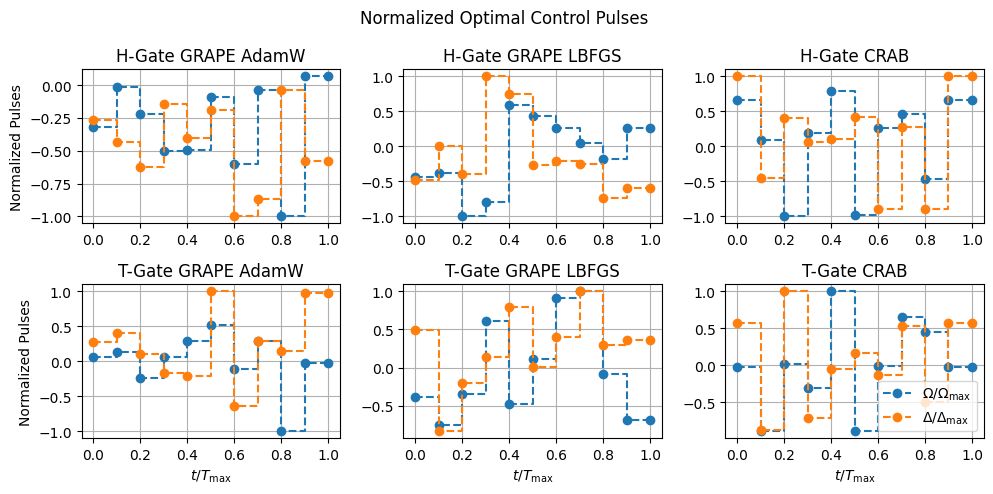

In [118]:
plt.figure(figsize=(10, 5))
plt.suptitle("Normalized Optimal Control Pulses")
# GRAPE AdamW Plot
plt.subplot(2, 3, 1)
plt.step(
    t_normalized_h,
    np.append(ux_grape_h_adam_norm, ux_grape_h_adam_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
    marker = 'o'
)
plt.step(
    t_normalized_h,
    np.append(uz_grape_h_adam_norm, uz_grape_h_adam_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
    marker = 'o'
)
plt.ylabel("Normalized Pulses")
plt.title("H-Gate GRAPE AdamW")
plt.grid(True)

# GRAPE LBFGS Plot
plt.subplot(2, 3, 2)
plt.step(
    t_normalized_h,
    np.append(ux_grape_h_lbfgs_norm, ux_grape_h_lbfgs_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
    marker="o",
)
plt.step(
    t_normalized_h,
    np.append(uz_grape_h_lbfgs_norm, uz_grape_h_lbfgs_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
    marker="o",
)
plt.title("H-Gate GRAPE LBFGS")
plt.grid(True)

# CRAB Plot
plt.subplot(2, 3, 3)
plt.step(
    t_normalized_h,
    np.append(ux_grape_h_crab_norm, ux_grape_h_crab_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
    marker="o",
)
plt.step(
    t_normalized_h,
    np.append(uz_grape_h_crab_norm, uz_grape_h_crab_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
    marker="o",
)
plt.title("H-Gate CRAB")
plt.grid(True)

# GRAPE AdamW Plot for T-Gate
plt.subplot(2, 3, 4)
plt.step(
    t_normalized_t,
    np.append(ux_grape_t_adam_norm, ux_grape_t_adam_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
    marker="o",
)
plt.step(
    t_normalized_t,
    np.append(uz_grape_t_adam_norm, uz_grape_t_adam_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
    marker="o",
)
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel("Normalized Pulses")
plt.title("T-Gate GRAPE AdamW")
plt.grid(True)

# GRAPE LBFGS Plot for T-Gate
plt.subplot(2, 3, 5)
plt.step(
    t_normalized_t,
    np.append(ux_grape_t_lbfgs_norm, ux_grape_t_lbfgs_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
    marker="o",
)
plt.step(
    t_normalized_t,
    np.append(uz_grape_t_lbfgs_norm, uz_grape_t_lbfgs_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
    marker="o",
)
plt.xlabel(r"$t/T_{\max}$")
plt.title("T-Gate GRAPE LBFGS")
plt.grid(True)

# CRAB Plot for T-Gate
plt.subplot(2, 3, 6)
plt.step(
    t_normalized_t,
    np.append(ux_grape_t_crab_norm, ux_grape_t_crab_norm[-1]),
    where="post",
    label=r"$\Omega/\Omega_{\max}$",
    linestyle="--",
    marker="o",
)
plt.step(
    t_normalized_t,
    np.append(uz_grape_t_crab_norm, uz_grape_t_crab_norm[-1]),
    where="post",
    label=r"$\Delta/\Delta_{\max}$",
    linestyle="--",
    marker="o",
)
plt.xlabel(r"$t/T_{\max}$")
plt.title("T-Gate CRAB")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/Gate_Optimal_Control_Pulses_Normalized_H_T.png"
)
plt.show()

In [112]:
# Normalize the CNOT-gate data arrays
u1x_grape_cnot_adam_norm = normalize(u1x_grape_cnot_adam)
u1z_grape_cnot_adam_norm = normalize(u1z_grape_cnot_adam)
u2x_grape_cnot_adam_norm = normalize(u2x_grape_cnot_adam)
u2z_grape_cnot_adam_norm = normalize(u2z_grape_cnot_adam)
coup_str_adam_norm = normalize(coup_str_adam)
u1x_grape_cnot_lbfgs_norm = normalize(u1x_grape_cnot_lbfgs)
u1z_grape_cnot_lbfgs_norm = normalize(u1z_grape_cnot_lbfgs)
u2x_grape_cnot_lbfgs_norm = normalize(u2x_grape_cnot_lbfgs)
u2z_grape_cnot_lbfgs_norm = normalize(u2z_grape_cnot_lbfgs)
coup_str_lbfgs_norm = normalize(coup_str_lbfgs)
u1x_crab_cnot_norm = normalize(u1x_crab_cnot)
u1z_crab_cnot_norm = normalize(u1z_crab_cnot)
u2x_crab_cnot_norm = normalize(u2x_crab_cnot)
u2z_crab_cnot_norm = normalize(u2z_crab_cnot)
coup_str_crab_norm = normalize(coup_str_crab)

# Normalize the time axis: t/Tmax (Tmax is the final time value)
Tmax_cnot = time_edges[-1]
t_normalized_cnot = time_edges / Tmax_cnot

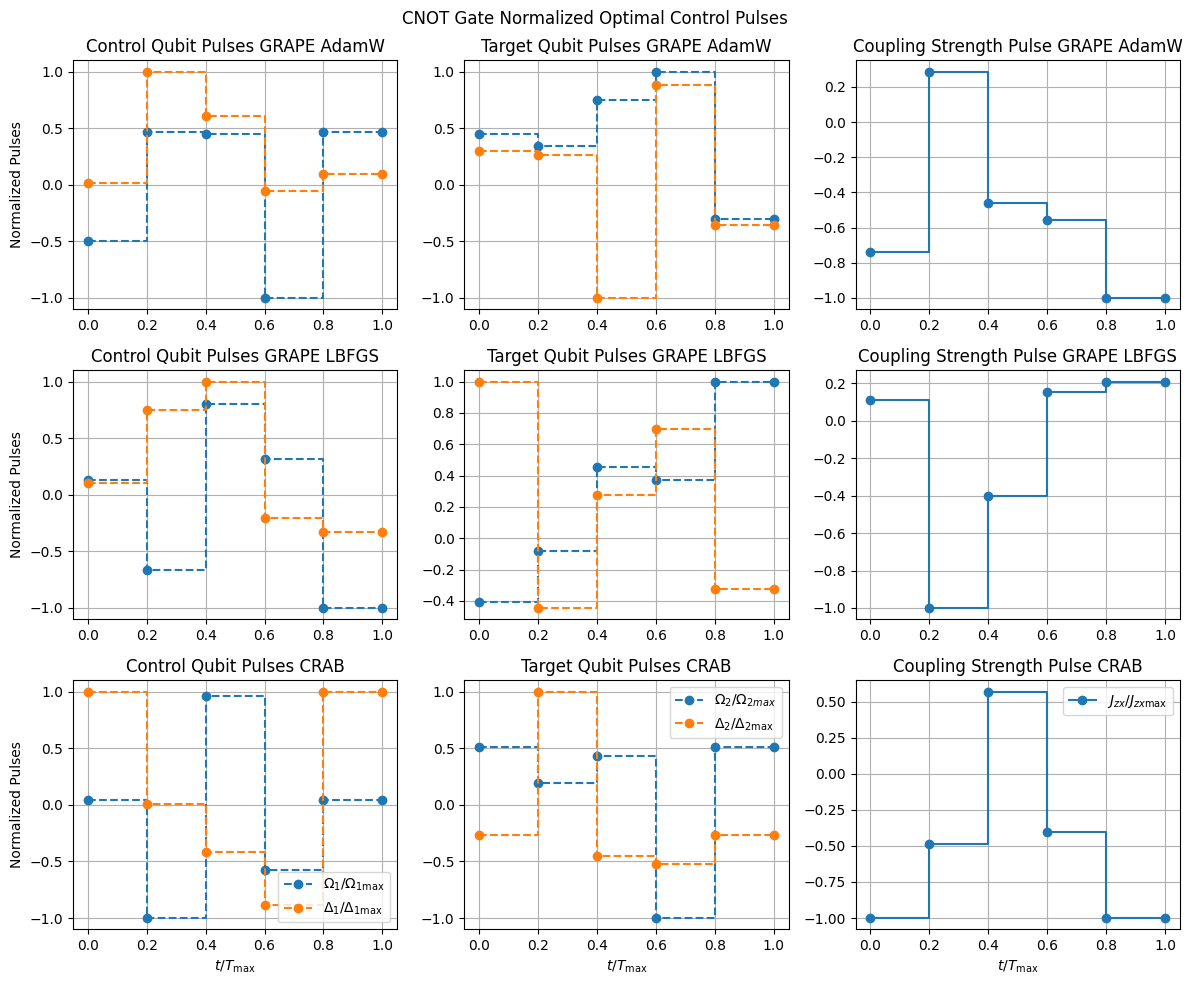

In [119]:
plt.figure(figsize=(12, 10))
plt.suptitle("CNOT Gate Normalized Optimal Control Pulses")
plt.subplot(3, 3, 1)
plt.step(
    t_normalized_cnot,
    np.append(u1x_grape_cnot_adam_norm, u1x_grape_cnot_adam_norm[-1]),
    where="post",
    label=r"$\Omega_1/\Omega_{1\max}$",
    linestyle="--",
    marker = 'o'
)
plt.step(
    t_normalized_cnot,
    np.append(u1z_grape_cnot_adam_norm, u1z_grape_cnot_adam_norm[-1]),
    where="post",
    label=r"$\Delta_1/\Delta_{1\max}$",
    linestyle="--",
    marker = 'o'
)
plt.title(r"Control Qubit Pulses GRAPE AdamW")
plt.ylabel(r"Normalized Pulses")
plt.grid(True)

plt.subplot(3, 3, 2)
plt.step(
    t_normalized_cnot,
    np.append(u2x_grape_cnot_adam_norm, u2x_grape_cnot_adam_norm[-1]),
    where="post",
    label=r"$\Omega_2/\Omega_{2max}$",
    linestyle="--",
    marker = 'o'
)
plt.step(
    t_normalized_cnot,
    np.append(u2z_grape_cnot_adam_norm, u2z_grape_cnot_adam_norm[-1]),
    where="post",
    label=r"$\Delta_2/\Delta_{2\max}$",
    linestyle="--",
    marker = 'o'
)
plt.title(r"Target Qubit Pulses GRAPE AdamW")
plt.grid(True)

plt.subplot(3, 3, 3)
plt.step(
    t_normalized_cnot,
    np.append(coup_str_adam_norm, coup_str_adam_norm[-1]),
    where="post",
    label=r"$J_{zx} / J_{zx\max}$",
    marker = 'o'
)
plt.title(r"Coupling Strength Pulse GRAPE AdamW")
plt.grid(True)

plt.subplot(3, 3, 4)
plt.step(
    t_normalized_cnot,
    np.append(u1x_grape_cnot_lbfgs_norm, u1x_grape_cnot_lbfgs_norm[-1]),
    where="post",
    label=r"$\Omega_1/\Omega_{1\max}$",
    linestyle="--",
    marker = 'o'
)
plt.step(
    t_normalized_cnot,
    np.append(u1z_grape_cnot_lbfgs_norm, u1z_grape_cnot_lbfgs_norm[-1]),
    where="post",
    label=r"$\Delta_1/\Delta_{1\max}$",
    linestyle="--",
    marker = 'o'
)
plt.title(r"Control Qubit Pulses GRAPE LBFGS")
plt.ylabel(r"Normalized Pulses")
plt.grid(True)

plt.subplot(3, 3, 5)
plt.step(
    t_normalized_cnot,
    np.append(u2x_grape_cnot_lbfgs_norm, u2x_grape_cnot_lbfgs_norm[-1]),
    where="post",
    label=r"$\Omega_2/\Omega_{2max}$",
    linestyle="--",
    marker = 'o'
)
plt.step(
    t_normalized_cnot,
    np.append(u2z_grape_cnot_lbfgs_norm, u2z_grape_cnot_lbfgs_norm[-1]),
    where="post",
    label=r"$\Delta_2/\Delta_{2\max}$",
    linestyle="--",
    marker = 'o'
)
plt.title(r"Target Qubit Pulses GRAPE LBFGS")
plt.grid(True)

plt.subplot(3, 3, 6)
plt.step(
    t_normalized_cnot,
    np.append(coup_str_lbfgs_norm, coup_str_lbfgs_norm[-1]),
    where="post",
    label=r"$J_{zx} / J_{zx\max}$",
    marker = 'o'
)
plt.title(r"Coupling Strength Pulse GRAPE LBFGS")
plt.grid(True)

plt.subplot(3, 3, 7)
plt.step(
    t_normalized_cnot,
    np.append(u1x_crab_cnot_norm, u1x_crab_cnot_norm[-1]),
    where="post",
    label=r"$\Omega_1/\Omega_{1\max}$",
    linestyle="--",
    marker = 'o'
)
plt.step(
    t_normalized_cnot,
    np.append(u1z_crab_cnot_norm, u1z_crab_cnot_norm[-1]),
    where="post",
    label=r"$\Delta_1/\Delta_{1\max}$",
    linestyle="--",
    marker = 'o'
)
plt.title(r"Control Qubit Pulses CRAB")
plt.xlabel(r"$t/T_{\max}$")
plt.ylabel(r"Normalized Pulses")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 8)
plt.step(
    t_normalized_cnot,
    np.append(u2x_crab_cnot_norm, u2x_crab_cnot_norm[-1]),
    where="post",
    label=r"$\Omega_2/\Omega_{2max}$",
    linestyle="--",
    marker = 'o'
)
plt.step(
    t_normalized_cnot,
    np.append(u2z_crab_cnot_norm, u2z_crab_cnot_norm[-1]),
    where="post",
    label=r"$\Delta_2/\Delta_{2\max}$",
    linestyle="--",
    marker = 'o'
)
plt.title(r"Target Qubit Pulses CRAB")
plt.xlabel(r"$t/T_{\max}$")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 9)
plt.step(
    t_normalized_cnot,
    np.append(coup_str_crab_norm, coup_str_crab_norm[-1]),
    where="post",
    label=r"$J_{zx} / J_{zx\max}$",
    marker = 'o'
)
plt.title(r"Coupling Strength Pulse CRAB")
plt.xlabel(r"$t/T_{\max}$")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/CNOT_Gate_Optimal_Control_Pulses_All.png",
    dpi=300,
)
plt.show()